In [1]:
using Pkg
Pkg.activate("..")

using Plots, StatsBase, CSV, DataFrames, Formatting, Latexify

  Activating project at `~/Research/RegionalSpanish/notebooks`


In [2]:
D = CSV.read("../data/SpanishLang/emoji-prediction.tsv.gz", DataFrame, delim='\t')

Row,country_code,model,n,precision,recall
,String3,String3,Int64,Float64,Float64
1,AR,ALL,92178,0.4777,0.4777
2,AR,AR,92178,0.4885,0.4885
3,AR,BO,92178,0.4846,0.4846
4,AR,BR,92178,0.4866,0.4866
5,AR,CA,92178,0.4855,0.4855
6,AR,CL,92178,0.4864,0.4864
7,AR,CO,92178,0.4879,0.4879
8,AR,CR,92178,0.4866,0.4866
9,AR,CU,92178,0.4792,0.4792


In [3]:
@info names(D)
@info unique(D.n)
E = subset(D, :n => n -> n .> 1000)
model_list = Set(E.country_code)
push!(model_list, "ALL")
subset!(E, :model => col -> [c in model_list for c in col])
setdiff(unique(D.country_code), unique(E.country_code))

┌ Info: ["country_code", "model", "n", "precision", "recall"]
└ @ Main In[3]:1
┌ Info: [92178, 748, 5036, 1053, 22959, 40292, 4296, 319, 4443, 7501, 57915, 1015, 1174, 2, 4374, 3876, 68578, 3117, 6857, 7875, 49, 10840, 2539, 21263, 8987, 5569]
└ @ Main In[3]:2


4-element Vector{String3}:
 "BO"
 "CU"
 "GQ"
 "PR"

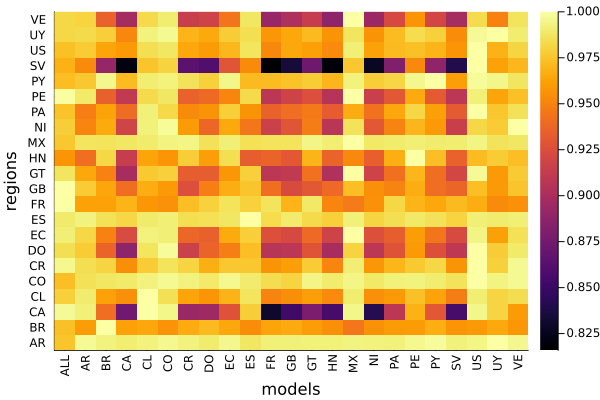

In [4]:
cclist = sort(String.(unique(E.country_code)))
model_list = sort(String.(collect(model_list)))
n = length(model_list) - 1

C = zeros(Float64, n, n+1)
for (i, cc) in enumerate(cclist)
    CC = E[E.country_code .== cc, :]
    sort!(CC, :model)
    
    for (j, row) in enumerate(eachrow(CC))
        C[i, j] = row.recall
    end
end

C_ = copy(C)
for r in eachrow(C_)
    #min_ = minimum(r)
    #r .= (r .- min_)
    max_ = maximum(r)
    r .= r ./ max_
end

heatmap(model_list, cclist, C_, xrotation=90, xticks=:all, yticks=:all, xlabel="models", ylabel="regions")
savefig("../figs/fig-heatmap-emoji15-prediction-task.pdf")
savefig("../figs/fig-heatmap-emoji15-prediction-task.png")
plot!(fmt=:png)
#heatmap(model_list, cclist, C, xrotation=90, xticks=:all, yticks=:all, fmt=:png)

In [5]:
C_ = copy(C)
k = 5
D = DataFrame(country_code=String[], min=Float64[], max=Float64[], local_rank=Int[], top5=String[])
local_rank_counter = 0
most_used = String[]
model_rank = zeros(Float64, length(model_list))

for (cc, row) in zip(cclist, eachrow(C_))
    p = sortperm(row, rev=true)
    model_rank .= model_rank .+ invperm(p)
    M = model_list[p]
    local_rank = findfirst(==(cc), M)
    local_rank_counter += local_rank
    #println(cclist[i] => M)
    M = M[1:k]
    append!(most_used, M)
    min_, max_ = extrema(row)
    push!(D, (cc, min_, max_, local_rank, join(M, ',')))
end

model_rank .= model_rank ./ length(cclist)
model_rank .= round.(model_rank, digits=2)

println(latexify(D, latex=false, env=:table))

popular = sort(collect(countmap(most_used)), by=last, rev=true)


\begin{tabular}{ccccc}
country_code & min & max & local_rank & top5\\
AR & 0.4777 & 0.49 & 3 & UY,PY,AR,PE,CO\\
BR & 0.4611 & 0.4879 & 1 & BR,ALL,DO,PY,CR\\
CA & 0.2934 & 0.3533 & 18 & CL,ALL,CO,MX,US\\
CL & 0.4257 & 0.4494 & 1 & CL,US,MX,AR,ES\\
CO & 0.4247 & 0.4365 & 2 & US,CO,VE,EC,GT\\
CR & 0.3689 & 0.388 & 9 & US,VE,ALL,MX,CO\\
DO & 0.3383 & 0.3813 & 13 & US,CO,VE,CL,ALL\\
EC & 0.3797 & 0.4138 & 9 & MX,US,CL,ALL,CO\\
ES & 0.4754 & 0.4855 & 1 & ES,AR,MX,US,VE\\
FR & 0.4187 & 0.4424 & 4 & ALL,GT,EC,FR,PA\\
GB & 0.3467 & 0.3756 & 23 & ALL,AR,ES,VE,MX\\
GT & 0.3489 & 0.3882 & 13 & MX,US,ALL,CO,ES\\
HN & 0.3354 & 0.3671 & 18 & PE,EC,BR,CR,UY\\
MX & 0.4233 & 0.4335 & 1 & MX,GT,CR,US,CO\\
NI & 0.3372 & 0.3718 & 18 & VE,CO,CL,MX,US\\
PA & 0.3658 & 0.3927 & 10 & US,CL,VE,CO,PE\\
PE & 0.3799 & 0.4196 & 9 & MX,ALL,US,AR,CO\\
PY & 0.4244 & 0.4417 & 1 & PY,US,BR,PE,UY\\
SV & 0.3226 & 0.3954 & 18 & US,CO,MX,CL,VE\\
US & 0.4041 & 0.4244 & 1 & US,MX,CO,ES,CL\\
UY & 0.4351 & 0.4572 & 1 & UY,US,CO,

18-element Vector{Pair{String, Int64}}:
  "US" => 17
  "CO" => 15
  "MX" => 13
  "VE" => 10
 "ALL" => 9
  "CL" => 9
  "ES" => 6
  "AR" => 5
  "UY" => 4
  "PE" => 4
  "BR" => 3
  "EC" => 3
  "GT" => 3
  "CR" => 3
  "PY" => 3
  "FR" => 1
  "DO" => 1
  "PA" => 1

In [6]:

D = CSV.read("../data/SpanishLang/embeddings-vocsize.tsv.gz", DataFrame)
D = subset(D, :model => col -> [(m in model_list) for m in col])
D = select!(D, Not(:dim))
@assert D.model == model_list
D[:, :avg_model_rank] = model_rank
sort!(D, :avg_model_rank)
println(latexify(D, env=:table, latex=false))
#D


\begin{tabular}{ccc}
model & vocsize & avg_model_rank\\
US & 292465 & 4.23\\
CO & 324635 & 6.05\\
MX & 438136 & 6.27\\
CL & 282737 & 6.91\\
VE & 271924 & 7.0\\
ALL & 1696232 & 8.45\\
PE & 178113 & 8.64\\
UY & 200032 & 8.73\\
EC & 147560 & 8.95\\
AR & 673424 & 9.41\\
ES & 571196 & 10.95\\
PY & 124162 & 11.14\\
BR & 127205 & 11.27\\
CR & 103086 & 12.5\\
PA & 111635 & 13.36\\
GT & 95252 & 13.64\\
DO & 108655 & 14.91\\
GB & 82418 & 18.0\\
NI & 68605 & 18.18\\
FR & 69843 & 18.91\\
CA & 63161 & 19.0\\
SV & 73833 & 19.14\\
HN & 60580 & 20.36\\
\end{tabular}

